Shape: (20631, 26)
Engines: 100
   unit  cycle     os1     os2    os3      s1      s2       s3       s4  \
0     1      1 -0.0007 -0.0004  100.0  518.67  641.82  1589.70  1400.60   
1     1      2  0.0019 -0.0003  100.0  518.67  642.15  1591.82  1403.14   
2     1      3 -0.0043  0.0003  100.0  518.67  642.35  1587.99  1404.20   
3     1      4  0.0007  0.0000  100.0  518.67  642.35  1582.79  1401.87   
4     1      5 -0.0019 -0.0002  100.0  518.67  642.37  1582.85  1406.22   

      s5  ...     s12      s13      s14     s15   s16  s17   s18    s19  \
0  14.62  ...  521.66  2388.02  8138.62  8.4195  0.03  392  2388  100.0   
1  14.62  ...  522.28  2388.07  8131.49  8.4318  0.03  392  2388  100.0   
2  14.62  ...  522.42  2388.03  8133.23  8.4178  0.03  390  2388  100.0   
3  14.62  ...  522.86  2388.08  8133.83  8.3682  0.03  392  2388  100.0   
4  14.62  ...  522.19  2388.04  8133.80  8.4294  0.03  393  2388  100.0   

     s20      s21  
0  39.06  23.4190  
1  39.00  23.4236  
2  38.

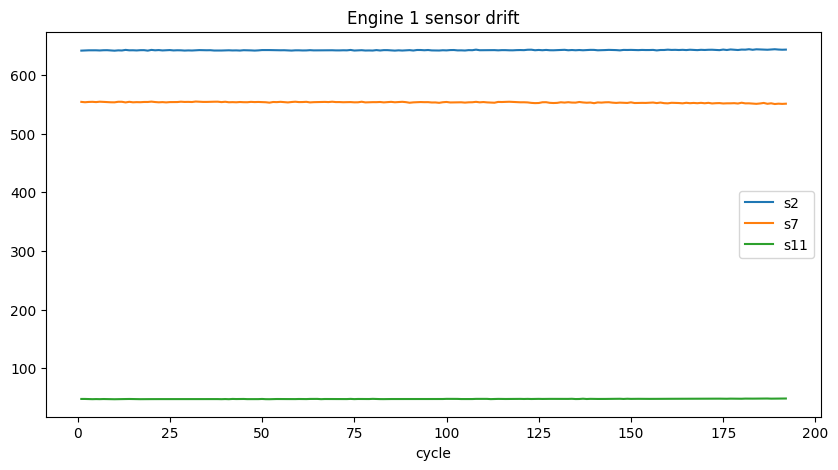

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# File path (adjust if needed)
file_path = "train_FD001.txt"

# Columns: 2 (unit, cycle) + 3 (ops) + 21 sensors = 26
cols = ["unit", "cycle", "os1", "os2", "os3"] + [f"s{i}" for i in range(1, 22)]

df = pd.read_csv(file_path, sep="\s+", header=None, names=cols)

print("Shape:", df.shape)
print("Engines:", df['unit'].nunique())
print(df.head())

# How long do engines run?
print("\nCycles per engine:")
print(df.groupby("unit")["cycle"].max().describe())

# Plot a few sensors for Engine 1
eng1 = df[df["unit"] == 1]
eng1.plot(x="cycle", y=["s2","s7","s11"], figsize=(10,5))
plt.title("Engine 1 sensor drift")
plt.show()


Top 10 sensors by variance:
s9     487.653568
s14    363.900490
s4      81.010886
s3      37.590994
s17      2.398667
s7       0.783388
s12      0.543985
s2       0.250053
s11      0.071336
s20      0.032669
dtype: float64

Bottom 5 sensors (likely uninformative):
s16    1.926023e-34
s10    0.000000e+00
s18    0.000000e+00
s19    0.000000e+00
s1     0.000000e+00
dtype: float64


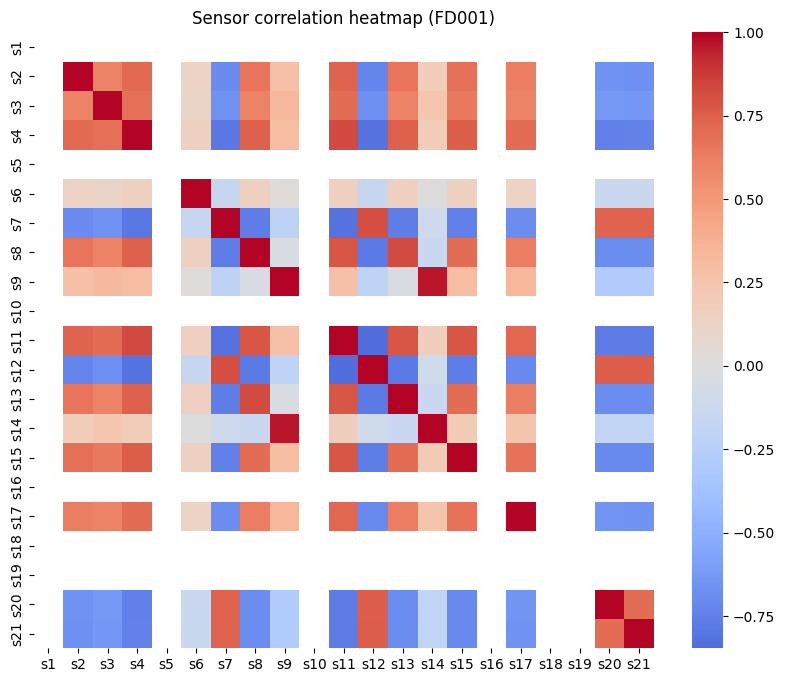

In [6]:
# All sensor columns
sensor_cols = [c for c in df.columns if c.startswith("s")]

# Variance across all engines (high variance = more informative)
variances = df[sensor_cols].var().sort_values(ascending=False)

print("Top 10 sensors by variance:")
print(variances.head(10))
print("\nBottom 5 sensors (likely uninformative):")
print(variances.tail(5))

# Plot correlations
import seaborn as sns
plt.figure(figsize=(10,8))
sns.heatmap(df[sensor_cols].corr(), cmap="coolwarm", center=0)
plt.title("Sensor correlation heatmap (FD001)")
plt.show()

Sensors kept: ['s3', 's4', 's7', 's9', 's12', 's14', 's17']


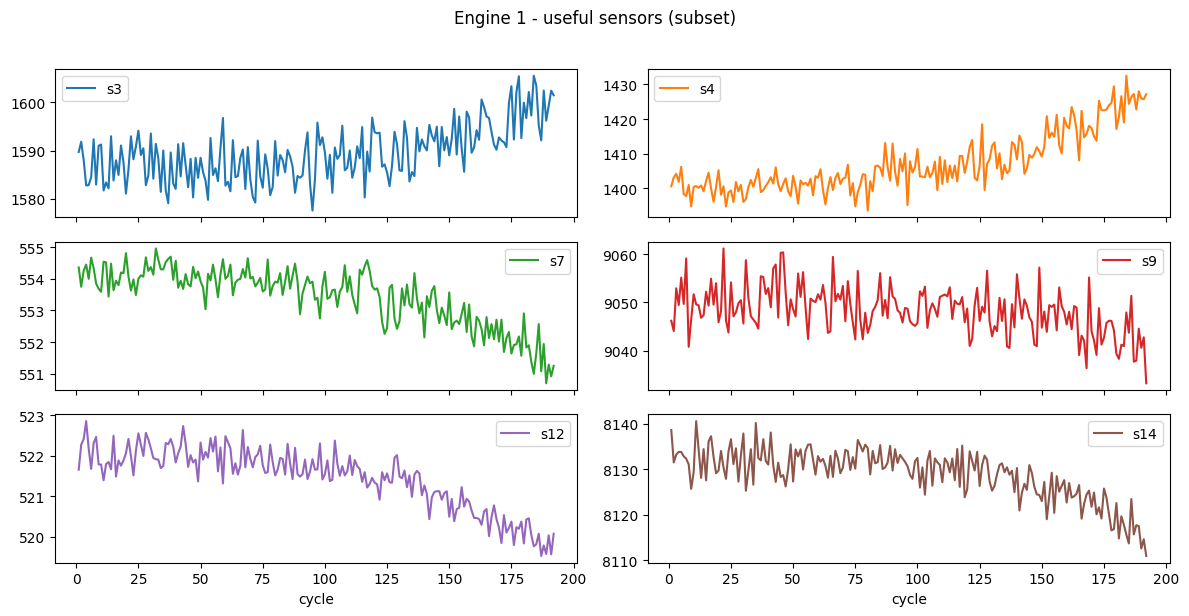

In [7]:
# Drop near-constant sensors (low variance)
useful_sensors = [c for c in sensor_cols if df[c].var() > 0.5]  # tweak threshold

print("Sensors kept:", useful_sensors)

# Plot a few for Engine 1 to see trends
eng1 = df[df["unit"] == 1]
eng1.plot(x="cycle", y=useful_sensors[:6], figsize=(12,6), subplots=True, layout=(3,2))
plt.suptitle("Engine 1 - useful sensors (subset)", y=1.02)
plt.tight_layout()
plt.show()


   unit  cycle  RUL
0     1      1  191
1     1      2  190
2     1      3  189
3     1      4  188
4     1      5  187


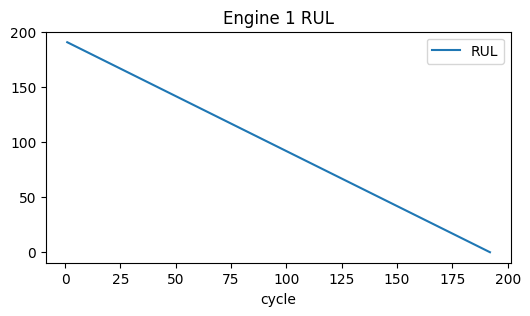

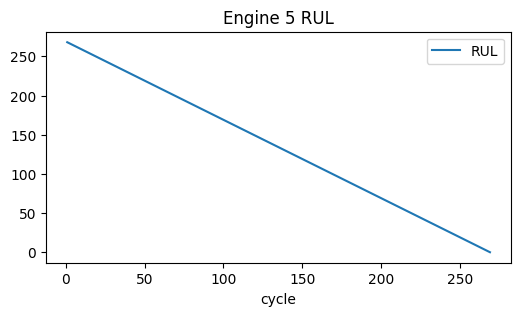

In [8]:
# Compute RUL (Remaining Useful Life) for training set
rul = df.groupby("unit")["cycle"].max().reset_index()
rul.columns = ["unit", "max_cycle"]

df = df.merge(rul, on="unit")
df["RUL"] = df["max_cycle"] - df["cycle"]

print(df[["unit","cycle","RUL"]].head())

# Plot RUL curve for a couple of engines
for eid in [1, 5]:
    eng = df[df["unit"] == eid]
    eng.plot(x="cycle", y="RUL", figsize=(6,3), title=f"Engine {eid} RUL")
    plt.show()


In [9]:
import numpy as np

def make_windows(df, sensors, window_size=30, step=1):
    X, y = [], []
    for unit, g in df.groupby("unit"):
        g = g.sort_values("cycle")
        vals = g[sensors].values
        rul_vals = g["RUL"].values
        for i in range(0, len(g)-window_size+1, step):
            X.append(vals[i:i+window_size])
            y.append(rul_vals[i+window_size-1])  # RUL at window end
    return np.array(X), np.array(y)

# Example: build windows on useful sensors
X, y = make_windows(df, useful_sensors, window_size=30)

print("X shape:", X.shape)  # (num_windows, window_size, num_sensors)
print("y shape:", y.shape)  # (num_windows,)


X shape: (17731, 30, 7)
y shape: (17731,)


In [14]:
import numpy as np
import pandas as pd

# assumes `df` is your FD001 train dataframe with RUL computed (from earlier cells)
sensor_cols = [c for c in df.columns if c.startswith("s")]

# Keep informative sensors (reuse your earlier list or recompute)
useful_sensors = [c for c in sensor_cols if df[c].var() > 0.5]

def healthy_mask(df, pct=0.2, min_cycles=30):
    m = np.zeros(len(df), dtype=bool)
    for uid, g in df.groupby("unit"):
        g = g.sort_values("cycle")
        cutoff = max(min_cycles, int(g["cycle"].max() * pct))
        m[g.index[g["cycle"] <= cutoff]] = True
    return m

H = healthy_mask(df, pct=0.2, min_cycles=30)
print(f"Healthy rows: {H.sum()} / {len(H)}")

def make_windows(df, sensors, window=30, step=1):
    X, meta = [], []
    for uid, g in df.groupby("unit"):
        g = g.sort_values("cycle")
        vals = g[sensors].values.astype(np.float32)
        cyc  = g["cycle"].values
        for i in range(0, len(g)-window+1, step):
            X.append(vals[i:i+window])
            meta.append((uid, int(cyc[i+window-1])))
    return np.array(X), np.array(meta)

W = 30
X, meta = make_windows(df, useful_sensors, window=W, step=1)  # X:(N,W,F)
print("X shape:", X.shape, "meta shape:", meta.shape)

# Label windows as healthy if their END row was healthy
row_index = []
start = 0
for uid, g in df.groupby("unit"):
    n = len(g)
    ends = np.arange(W-1, n)  # end indices for windows
    row_index.extend(g.index[ends].tolist())
healthy_win = H[row_index]
print("Healthy windows:", healthy_win.sum(), "/", len(healthy_win))


Healthy rows: 4102 / 20631
X shape: (17731, 30, 7) meta shape: (17731, 2)
Healthy windows: 1202 / 17731


In [18]:
from sklearn.preprocessing import StandardScaler

B, W, F = X.shape
Xflat = X.reshape(B, W*F)

scaler = StandardScaler()
Xh = scaler.fit_transform(Xflat[healthy_win])      # fit on healthy
Xall = np.empty_like(Xflat, dtype=np.float32)
Xall[healthy_win]  = Xh
Xall[~healthy_win] = scaler.transform(Xflat[~healthy_win])
print("Xflat shape:", Xflat.shape)
print("Xall shape:", Xall.shape)
print("First row (scaled):", Xall[0][:10])


Xflat shape: (17731, 210)
Xall shape: (17731, 210)
First row (scaled): [ 0.7131985  -0.21646544  0.5411781  -1.2366748  -0.596122    0.09610651
 -0.14099295  1.1757073   0.21125576 -0.44223002]


In [19]:
from sklearn.ensemble import IsolationForest
import numpy as np

# Train IF on healthy windows only
iso = IsolationForest(
    n_estimators=300,
    contamination=0.02,   # small prior; tweak later
    random_state=42,
    n_jobs=-1
)
iso.fit(Xall[healthy_win])

# sklearn's score_samples: higher = more normal
# invert so larger = more anomalous
raw_scores = -iso.score_samples(Xall)

print("Scores:", raw_scores.shape, "healthy:", healthy_win.sum())


Scores: (17731,) healthy: 1202


In [20]:
import pandas as pd

def ewma_by_engine(scores, meta, alpha=0.2):
    out = np.zeros_like(scores, dtype=float)
    dfm = pd.DataFrame({"uid": meta[:,0], "score": scores})
    for uid, idx in dfm.groupby("uid").groups.items():
        idx = list(idx)
        s = scores[idx]
        sm = np.empty_like(s, dtype=float)
        sm[0] = s[0]
        for i in range(1, len(s)):
            sm[i] = alpha*s[i] + (1-alpha)*sm[i-1]
        out[idx] = sm
    return out

score_smooth = ewma_by_engine(raw_scores, meta, alpha=0.2)

# Threshold from healthy windows only (95th percentile)
thr = np.percentile(score_smooth[healthy_win], 95)
alerts = score_smooth > thr

print("Threshold:", thr, "| alert rate (all windows):", alerts.mean().round(3))


Threshold: 0.484874414465275 | alert rate (all windows): 0.434


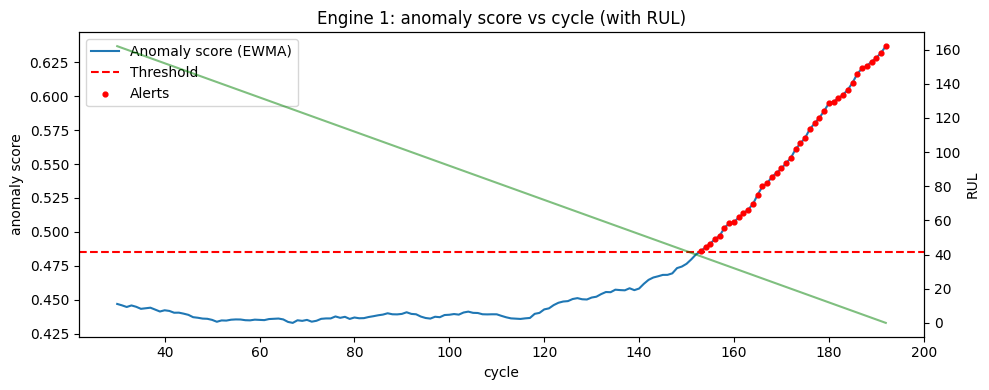

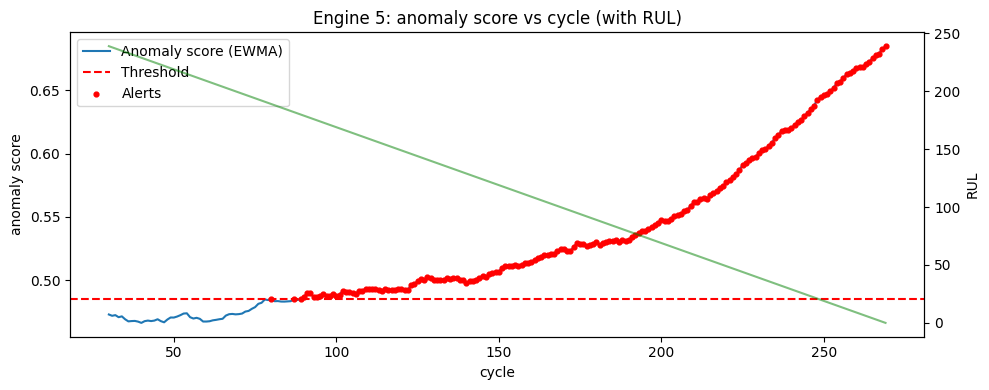

In [21]:
import matplotlib.pyplot as plt

def plot_engine(uid):
    m = meta[:,0] == uid
    cyc_w = meta[m,1]
    s = score_smooth[m]
    a = alerts[m]

    # Align RUL to window ends (W-1 .. end)
    eng = df[df["unit"] == uid].sort_values("cycle")
    cyc = eng["cycle"].values[W-1:]
    rul = eng["RUL"].values[W-1:]

    fig, ax1 = plt.subplots(figsize=(10,4))
    ax1.plot(cyc_w, s, label="Anomaly score (EWMA)")
    ax1.axhline(thr, ls="--", color="r", label="Threshold")
    ax1.scatter(cyc_w[a], s[a], s=12, color="r", label="Alerts", zorder=3)
    ax1.set_xlabel("cycle"); ax1.set_ylabel("anomaly score")
    ax1.legend(loc="upper left")

    ax2 = ax1.twinx()
    ax2.plot(cyc, rul, color="g", alpha=0.5, label="RUL")
    ax2.set_ylabel("RUL")
    plt.title(f"Engine {uid}: anomaly score vs cycle (with RUL)")
    fig.tight_layout(); plt.show()

# Try a couple of engines
plot_engine(1)
plot_engine(5)


In [22]:
def first_alert_cycle(uid):
    m = meta[:,0] == uid
    cyc = meta[m,1]
    a = alerts[m]
    return int(cyc[a][0]) if a.any() else None

def first_cycle_where_RUL_leq(uid, T=30):
    g = df[df["unit"] == uid].sort_values("cycle")
    m = g["RUL"].values <= T
    if m.any():
        return int(g["cycle"].values[np.argmax(m)])
    return None

uids = np.unique(meta[:,0])
lead_times = []
false_alerts_total = 0

for u in uids:
    t_alert = first_alert_cycle(u)
    t_rul30 = first_cycle_where_RUL_leq(u, 30)
    # count false alerts strictly before the RUL<=30 milestone (if it exists)
    m = meta[:,0] == u
    cyc = meta[m,1]
    a  = alerts[m]
    if t_rul30 is not None:
        false_alerts_total += int((a & (cyc < t_rul30)).sum())
    if (t_alert is not None) and (t_rul30 is not None):
        lead_times.append(t_rul30 - t_alert)

print("Mean lead time to RUL<=30 (cycles):", (np.mean(lead_times) if lead_times else None))
print("False alerts before RUL<=30 (total):", false_alerts_total)
print("Engines with at least one alert before RUL<=30:", sum([lt>0 for lt in lead_times]))


Mean lead time to RUL<=30 (cycles): 48.66
False alerts before RUL<=30 (total): 4646
Engines with at least one alert before RUL<=30: 89


In [23]:
# Compute per-sensor mean/std from healthy windows' last timestep
last_healthy = X[healthy_win, -1, :]  # (n_healthy, F)
mu = last_healthy.mean(axis=0)
sd = last_healthy.std(axis=0) + 1e-8

def topk_contrib_for_window(idx, k=3):
    last = X[idx, -1, :]
    z = np.abs((last - mu) / sd)
    top = np.argsort(z)[::-1][:k]
    return [(useful_sensors[i], float(z[i])) for i in top]

# Example: first alert for engine 1
m = (meta[:,0] == 1) & alerts
idxs = np.where(m)[0]
if len(idxs):
    print("Top contributors at first alert (engine 1):", topk_contrib_for_window(int(idxs[0])))


Top contributors at first alert (engine 1): [('s12', 2.531891345977783), ('s4', 2.086667537689209), ('s7', 2.0655198097229004)]


In [24]:
import os, numpy as np
os.makedirs("artifacts_fd001", exist_ok=True)
np.save("artifacts_fd001/X.npy", X)
np.save("artifacts_fd001/meta.npy", meta)
np.save("artifacts_fd001/healthy_win.npy", healthy_win)
np.save("artifacts_fd001/score_smooth.npy", score_smooth)
np.save("artifacts_fd001/alerts.npy", alerts)
print("Saved to artifacts_fd001/")


Saved to artifacts_fd001/
